# <center> Shrirang Kanade MEML - Final Project
---

## Import Necessary Libraries

In [2]:
# Not all are necessary, maybe we need some other libraries as we go ahead. 
import numpy as np 
import math
import pandas as pd 
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, Sequence
import datetime

## Data Preprocessing

In [3]:
# Create variables for root directories
imgs_dir = "/kaggle/input/ai4mars-terrainaware-autonomous-driving-on-mars/ai4mars-dataset-merged-0.1/msl/images/edr"
masks_dir = "/kaggle/input/ai4mars-terrainaware-autonomous-driving-on-mars/ai4mars-dataset-merged-0.1/msl/labels/train"

In [4]:
# Generate lists of names of images and masks
imgs = os.listdir(imgs_dir)
msks = os.listdir(masks_dir)

In [5]:
# Check the length of the images and masks
len(imgs), len(msks)

(18130, 16064)

In [6]:
'''There are more images than masks - some masks are not present in the labels'''

# Check using random integers between 1 to 1000 if the names are same or not
rand_num = np.random.randint(1, 10000)
imgs[rand_num], msks[rand_num]

('NLB_560311677EDR_F0661112NCAM00353M1.JPG',
 'NLB_584637252EDR_F0712876NCAM00353M1.png')

In [7]:
# We need to fetch only those images whose masks are present
img_dir = []
mask_dir = []
test_img_dir = []
test_mask_dir = []
ct = 0
flag=0

for mask_name in msks:

    if  flag ==0:
        img_name = mask_name[:-4]+'.JPG'
        if img_name in imgs:
            img_dir.append(os.path.join(imgs_dir, img_name))
            mask_dir.append(os.path.join(masks_dir, mask_name)) 
        ct+=1
        if ct>=10000: 
            flag=1
    if flag==1:                            #Getting all images with mask for testing model at last
        img_name = mask_name[:-4]+'.JPG'   #this images will not be used in training and validation
        if img_name in imgs:
            test_img_dir.append(os.path.join(imgs_dir, img_name))
            test_mask_dir.append(os.path.join(masks_dir, mask_name))
        else:
            break
     

In [8]:
# Check he size now
len(img_dir), len(mask_dir),len(test_img_dir),len(test_mask_dir)

(10000, 10000, 6065, 6065)

/kaggle/input/ai4mars-terrainaware-autonomous-driving-on-mars/ai4mars-dataset-merged-0.1/msl/images/edr/NLB_524621561EDR_F0562428NCAM00654M1.JPG 
 /kaggle/input/ai4mars-terrainaware-autonomous-driving-on-mars/ai4mars-dataset-merged-0.1/msl/labels/train/NLB_524621561EDR_F0562428NCAM00654M1.png



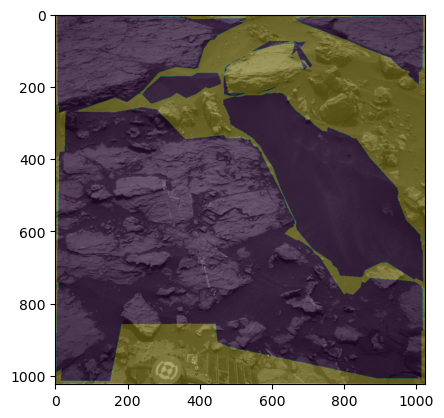

In [9]:
# Check if a particular index calls an image and its respective mask
rand_num = np.random.randint(1, 10000)
print(img_dir[rand_num], '\n', mask_dir[rand_num])
print()

# Plot the images to see the result
plt.imshow(cv2.imread(img_dir[rand_num]))
plt.imshow(cv2.imread(mask_dir[rand_num], 0), alpha = 0.3)
plt.show()

/kaggle/input/ai4mars-terrainaware-autonomous-driving-on-mars/ai4mars-dataset-merged-0.1/msl/images/edr/NLB_552588764EDR_F0641980NCAM00312M1.JPG 
 /kaggle/input/ai4mars-terrainaware-autonomous-driving-on-mars/ai4mars-dataset-merged-0.1/msl/labels/train/NLB_552588764EDR_F0641980NCAM00312M1.png



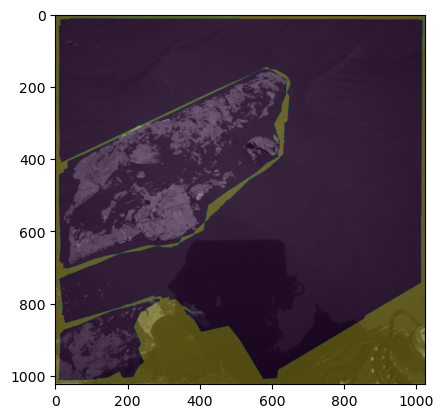

In [10]:
#Testing Images which will be used by user are stored in test_img_dir and test_mask_dir
rand_num = np.random.randint(1, 6065)
print(test_img_dir[rand_num], '\n', test_mask_dir[rand_num])
print()

# Plot the images to see the result
plt.imshow(cv2.imread(test_img_dir[rand_num]))
plt.imshow(cv2.imread(test_mask_dir[rand_num], 0), alpha = 0.3)
plt.show()


In [11]:
# Check the unique values of mask
np.unique(cv2.imread(mask_dir[rand_num],0))

array([  0,   2, 255], dtype=uint8)

- We have masked labelled with the following pixels:- 0, 1, 2, 3, 255 
- We can change 255 to 4 for the quick and better understanding for our machine.
- We shall do it in a while!

In [12]:
# Looks good! We will keep 7500 of these images for training, 2500 for Validating

'''TRAINING'''
X_train = img_dir[:8000]
y_train = mask_dir[:8000]

'''VALIDATION'''
X_valid = img_dir[8000:10000]
y_valid = mask_dir[8000:10000]

In [13]:
# Check the length now of the lists
print(len(X_train), len(y_train))
print(len(X_valid), len(y_valid))

8000 8000
2000 2000


## Mars Dataset class

In [18]:
# Creating a class to preprcess images and masks and generate batches for large dataset
class MarsDataset(Sequence):
    
    '''Constructor'''
    def __init__(self, x_set, y_set, batch_size, dims, classes):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.img_height, self.img_width = dims
        self.classes = classes
    
    '''    The purpose of the __len__() method is to provide information about the number of batches that can be 
    used during training, validation or testing processes. It can be used by other methods in the custom 
    class or external functions to iterate through the batches and process the data in smaller chunks, 
    which can be useful for handling large datasets or reducing memory usage during training.
    
    For example, we have 8000 images for training, hence if batch size is 16,
    we will have 8000/16 = 500. This indicates we have 16 batches with 500 images each.
    
    You will see this number below the epochs while training'''
    def __len__(self):
        # ceil rounds up any decimal output ensuring that the total number of batches is sufficient to cover all the images 
        return math.ceil(len(self.x) / self.batch_size) 
    
    '''
    __getitem__() will be used to fetch batch of images that will be generated from this class.
    This is an efficient way to create batches for large datasets. Of course, you can try other methods too!
    '''
    def __getitem__(self, idx):
        
        # Prepare batches
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size] # images path
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size] # maks path
         
        # Create arrays of zeros of same size as image and add the preprocessed image to it
        count = 0                                                                     # will be used to store preprocessed images
        xtr = np.zeros((self.batch_size, self.img_height, self.img_width, 3))         # arrays for images
        for filename in batch_x:                                                      # for each iamges in a batch
            img = cv2.imread(filename)                                                # create array of image
            img = cv2.resize(img, dsize = (self.img_height, self.img_width)) / 255.0  # resize and normalize it
            img = img.astype(np.float32)                                              # cast to float32 for efficiency
            xtr[count] = img                                                          # add preprocessed image to the batch array
            count+=1                                                                  # increment the counter and repeat for each batch
        
        # Create arrays of zeros of same size as mask and add the preprocessed mask to it
        count = 0                                                                        # intialize the counter for mask        
        ytr = np.zeros((self.batch_size, self.img_height, self.img_width, self.classes)) # will be used to store preprocessed masks
        for filename in batch_y:                                                         # for each mask in a batch
            mask = cv2.imread(filename, 0)                                               # create gray scale array for mask
            mask = cv2.resize(mask, dsize = (self.img_height, self.img_width),           # resize the mask
                              interpolation = cv2.INTER_NEAREST)                         # using nearest interpolation
            mask[mask==255] = 4                                                          # Change all 255 pixels to 4
            mask = to_categorical(mask, self.classes)                                    # one hot encoided mask [0 0 0 0 1]
            ytr[count] = mask                                                            # add preprocessed mask to the batch array
            count+=1                                                                     # increment the counter
        
        '''Return preprocessed batches of images and masks'''
        return xtr, ytr

In [19]:
# Choose batch size and input dims, num_classes should be 5 as there are 5 different pixels to segment
batch_size = 16
dims = (480, 480)
num_classes = 5

# Generate the data in batches for training and validation
train_dataset = MarsDataset(X_train, y_train, batch_size, dims, num_classes)
valid_dataset = MarsDataset(X_valid, y_valid, batch_size, dims, num_classes)

## Visualise the masks 

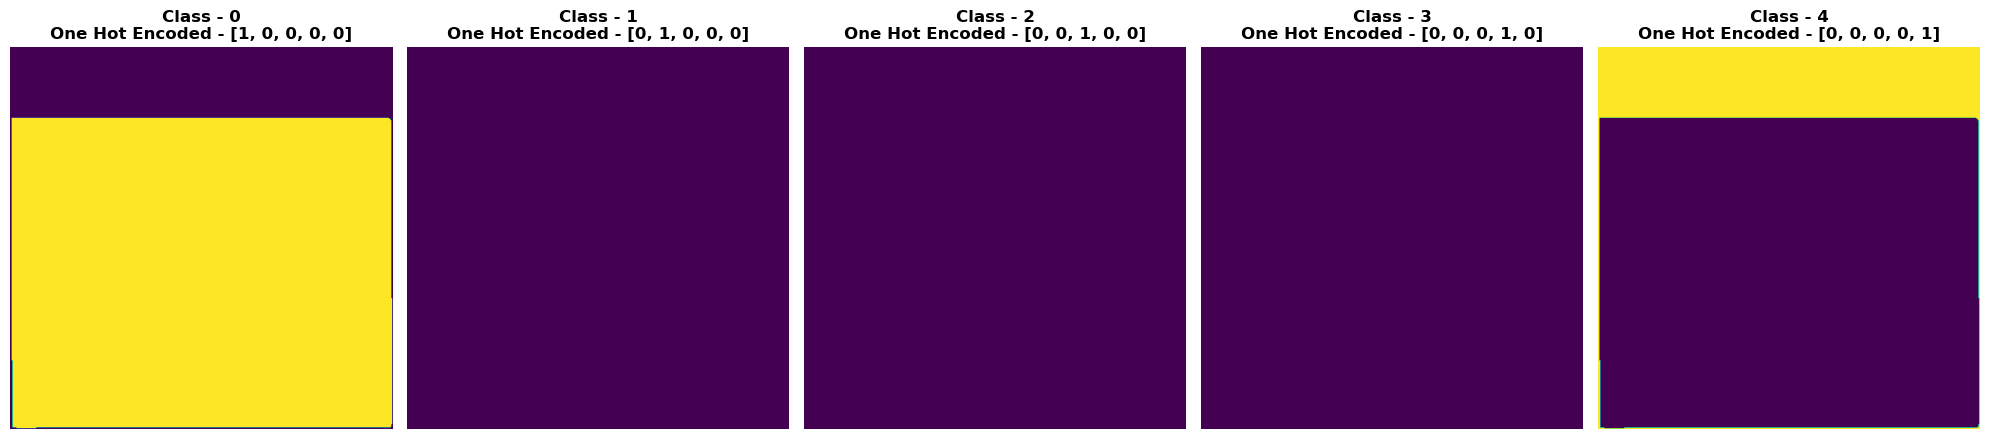

In [20]:
# Pulling out the last mask from the first batch of train_dataset
plt.figure(figsize = (20,5))
for class_val in range(num_classes):
    ohe_vec = [0]*5
    
    plt.subplot(1, 5, class_val+1)
    plt.imshow(train_dataset[0][1][-1][:,:,class_val])
    ohe_vec[class_val] = 1
    plt.title(f'Class - {class_val}\nOne Hot Encoded - {ohe_vec}', weight = 'bold')
    plt.axis('off')

plt.tight_layout()

## Segmentation models

In [21]:
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.6 MB/s eta 0:00:00


In [22]:
# By default it tries to import keras, if it is not installed, it will try to start with tensorflow.keras framework
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `tf.keras` framework.


## VGG19 Backbone

In [23]:
# Prepare arguments for UNET segmentation_model
BACKBONE = 'vgg19'                 # Transfer Learning - Backbone
input_shape = (480, 480, 3)        # Input Shape to the model
n_classes = 5                      # Number of different pixels to segment
activation = 'softmax'             # Last layer activation
encoder_weights = 'imagenet'       # Pretrained imagenet weights to be used

# segmentation_model basically will create a mirror image of our backbone as expansion path and add to the contraction path
model = sm.Unet(backbone_name = BACKBONE, 
                input_shape = input_shape, 
                classes = n_classes, 
                activation = activation,
                encoder_weights = encoder_weights)

# Get the summary and compare it with above block diagram
model.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 480, 480, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 480, 480, 64  36928       ['block1_conv1[0][0]']           
                             

## Callbacks

**Callbacks** is a tool to customize the behavior of a Keras model during training, evaluation, or inference.

- **ModelCheckpoint:** used  to periodically save your model during training.
- **ReduceLROnPlateau:** Reduce learning rate when a metric has stopped improving.
- **EarlyStopping:** Stop training when a monitored metric has stopped improving.
- **TensorBoard:** Enable visualizations for TensorBoard.

In [24]:
# Hyperparameters 
lr = 1e-3          # Learning Rate
batch_size = 16    # Batch Size to use while training
epochs =  20


# Total Epochs to be used for training


# Compiling the model
model.compile(optimizer = tf.keras.optimizers.Adam(lr),  # Optimzer for back propagation
              loss = sm.losses.cce_jaccard_loss,         # Jaccard Loss for Semantic Segmentation - You can surely change this as well depending on your research!!
              metrics = [sm.metrics.iou_score])          # IOU Metric for Segmantic Segmentation - You can add more metrics for example f1 score!!

# This is same as len method we used in the dataset generator class - MarsDataset()
train_steps = len(X_train)//batch_size
valid_steps = len(X_valid)//batch_size


# Prepare callback
current_datetime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
callbacks = [
        
        # Save only the model that has best val_iou - you can then use this .h5 file for deployment if needed
        tf.keras.callbacks.ModelCheckpoint(filepath=f'models/MarsSegmentationModel_{current_datetime}.h5',
                        monitor='val_iou_score', verbose=0, 
                        mode='max', save_best_model=True),  
        
        # if val_iou is saturated for 4 epochs, decrease the lr by 0.1
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", mode='max', patience=4,
                          factor=0.1, verbose=0, min_lr=1e-6), 
        # if val_iou satured for 5 epochs, stop the training     
        tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=5, verbose=0, mode='max'), 
        
        # we won't really need this callback but yes this is also one of the popular callbacks
        tf.keras.callbacks.TensorBoard(f'models/logs_{current_datetime}')
    ]







### Train the model

In [100]:

model_history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=callbacks
    )

Epoch 1/20
500/500 [==============================] - 748s 1s/step - loss: 0.8576 - iou_score: 0.3266 - val_loss: 1.2232 - val_iou_score: 0.2029 - lr: 0.0010
Epoch 2/20
500/500 [==============================] - 538s 1s/step - loss: 0.7551 - iou_score: 0.4010 - val_loss: 0.8515 - val_iou_score: 0.3355 - lr: 0.0010
Epoch 3/20
500/500 [==============================] - 538s 1s/step - loss: 0.7077 - iou_score: 0.4346 - val_loss: 0.7067 - val_iou_score: 0.4325 - lr: 0.0010
Epoch 4/20
500/500 [==============================] - 542s 1s/step - loss: 0.6684 - iou_score: 0.4651 - val_loss: 0.7623 - val_iou_score: 0.4112 - lr: 0.0010
Epoch 5/20
500/500 [==============================] - 541s 1s/step - loss: 0.6410 - iou_score: 0.4867 - val_loss: 0.7382 - val_iou_score: 0.4319 - lr: 0.0010
Epoch 6/20
500/500 [==============================] - 542s 1s/step - loss: 0.6175 - iou_score: 0.5048 - val_loss: 0.9639 - val_iou_score: 0.3405 - lr: 0.0010
Epoch 7/20
500/500 [==============================] 

## Model Performance

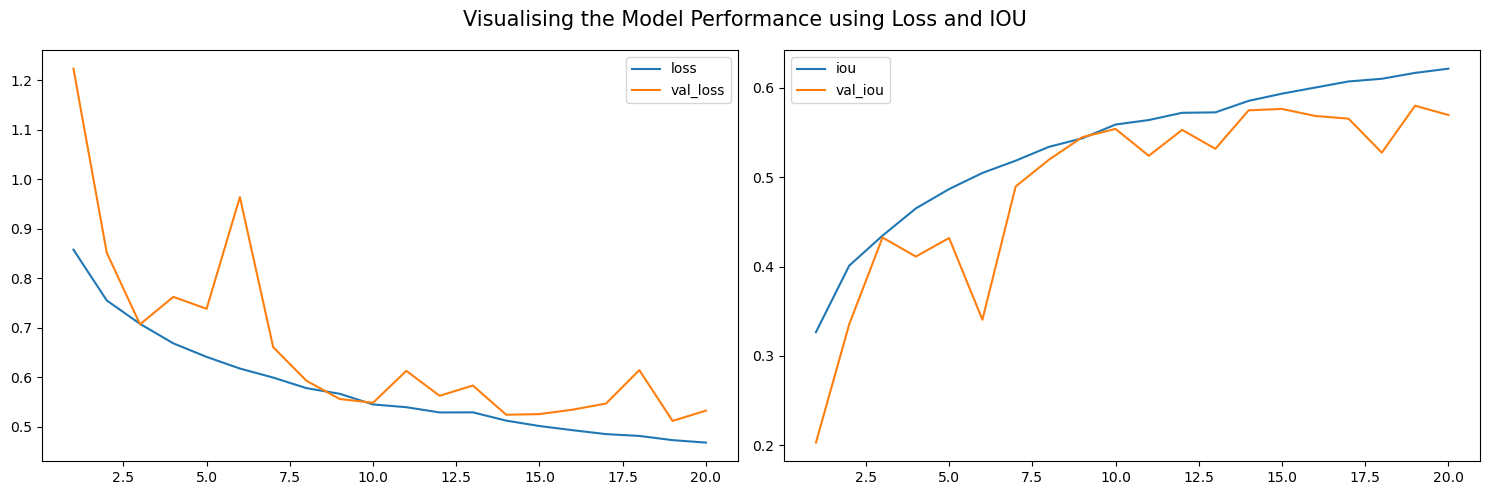

In [101]:
## Visualise the Model Performance
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

iou = model_history.history['iou_score']
val_iou = model_history.history['val_iou_score']

epochs = range(1, len(loss)+1)

plt.figure(figsize = (15, 5))

plt.suptitle('Visualising the Model Performance using Loss and IOU', fontsize = 15)

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label = 'loss')
plt.plot(epochs, val_loss, label = 'val_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, iou, label = 'iou')
plt.plot(epochs, val_iou, label = 'val_iou')
plt.legend()

plt.tight_layout()
plt.show()

## Loading the model

In [25]:

# loading the model
from tensorflow.keras.models import load_model
model = load_model(f'/kaggle/input/final-model/MarsSegmentationModel_20230308-131105.h5',custom_objects={'categorical_crossentropy_plus_jaccard_loss':sm.losses.cce_jaccard_loss,'iou_score':sm.metrics.IOUScore})
'''Model file link : https://drive.google.com/file/d/1j1dx9Rt3uuKMQNy4CobIwzwUZVnKevQk/view?usp=sharing '''

## Test the model

In [26]:

'''This lists contains images and masks for testing that is not seen by the model.
We separated them at data separation section'''

print(len(test_img_dir),len(test_mask_dir))

6065 6065


In [27]:
rand_num = np.random.randint(1, 6065)
print(test_img_dir[rand_num].split('/')[-1],'\n',test_mask_dir[rand_num].split('/')[-1])
print()

NLB_614018518EDR_F0760988NCAM00289M1.JPG 
 NLB_614018518EDR_F0760988NCAM00289M1.png



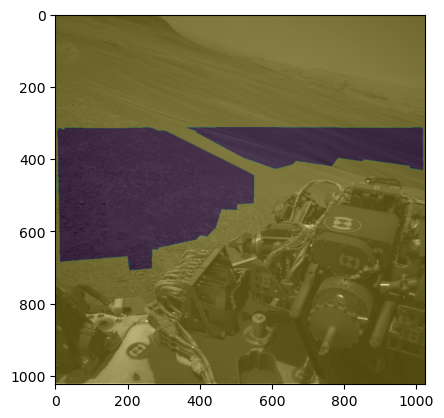

In [28]:
# Plot the images to see the result
plt.imshow(cv2.imread(test_img_dir[rand_num]))
plt.imshow(cv2.imread(test_mask_dir[rand_num], 0), alpha = 0.3)
plt.show()

In [32]:
'''There are total 6065 images so out of them only 50 are displayed, user can select any 
image out of 6065 as there address in stored in test_img_dir,this limit of 50 images is 
applied only to show that user can select index and images name is attached to it.'''
print("Index","\t\t\tImage")
for index,image in enumerate(test_img_dir):
    image = image.split("/")[-1]
    print(" ",index,"\t"+image)
    if index>49:
        break

Index 			Image
  0 	NLB_578602532EDR_F0700886NCAM00251M1.JPG
  1 	NLB_442417037EDR_F0250242NCAM00278M1.JPG
  2 	NLB_486005346EDR_F0481570NCAM07813M1.JPG
  3 	NLB_584545908EDR_F0712804NCAM00312M1.JPG
  4 	NLB_625030096EDR_F0770328NCAM00295M1.JPG
  5 	NLB_569631170EDR_F0672478NCAM00278M1.JPG
  6 	NLB_458661266EDR_F0390516NCAM00297M1.JPG
  7 	NLB_547801093EDR_F0630346NCAM07753M1.JPG
  8 	NLB_512994896EDR_F0540000NCAM00266M1.JPG
  9 	NLB_557915429EDR_F0653200NCAM07753M1.JPG
  10 	NLB_578782764EDR_F0701000NCAM00207M1.JPG
  11 	NLB_525428024EDR_F0571020NCAM00290M1.JPG
  12 	NLB_548420770EDR_F0631420NCAM07753M1.JPG
  13 	NLB_445440534EDR_F0261102NCAM00265M1.JPG
  14 	NLB_625205277EDR_F0770574NCAM00296M1.JPG
  15 	NLB_543262844EDR_F0612740NCAM00284M1.JPG
  16 	NLB_494970835EDR_F0492374NCAM00266M1.JPG
  17 	NLB_445615972EDR_F0261274NCAM00266M1.JPG
  18 	NLB_606124446EDR_F0750012NCAM00385M1.JPG
  19 	NLB_427948669EDR_F0090366NCAM00255M1.JPG
  20 	NLB_530568740EDR_F0582136NCAM00654M1.JPG
  21 	NL

## User Interface

Enter the num:  12


Test Image :- NLB_525428024EDR_F0571020NCAM00290M1.JPG
Test Mask :- NLB_525428024EDR_F0571020NCAM00290M1.png


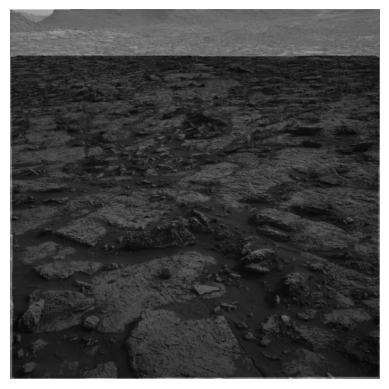

In [33]:
'''Getting the input from user side'''

input_img_index = int(input("Enter the num: "))
for index,image in enumerate(test_img_dir):
    if input_img_index-1 == index:
        plt.imshow(cv2.imread(image))
        break

        
input_img = image
mask_index = index  #assigining the input index to mask index so we  
                    #can fetch the asscociated mask of image


print("Test Image :-",input_img.split('/')[-1])  
print("Test Mask :-",test_mask_dir[index].split('/')[-1])


plt.imshow(cv2.imread(input_img))
plt.imshow(cv2.imread(test_mask_dir[mask_index]),alpha = 0.3)
plt.axis('off') 

test_mask_path = test_mask_dir[mask_index]  #Getting the test mask path

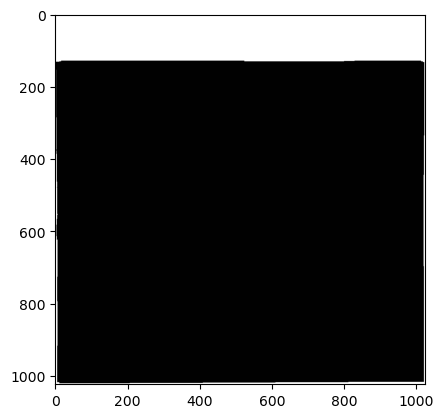

In [34]:
'''IMAGE MASK'''
plt.imshow(cv2.imread(test_mask_path))
plt.show()

## Preprocess input

In [37]:
'''PREPROCESSING OF INPUT IMAGE'''
def preprocess_input(input_img):
    test_img = cv2.imread(input_img)
    test_img = cv2.resize(test_img, dsize = (480,480))
    test_img = np.asarray(test_img, dtype = np.float32) / 255.0
    return test_img

## Model Prediction

In [38]:
 '''Predicting the mask using our segmentation model from saved model
    Passing the image to the model for prediction'''

def model_prediction(test_img,test_mask_path):
#     print(test_mask_path.split("/")[-1])
    predicted_mask = model.predict(np.expand_dims(test_img, axis = 0))  

    # Converting the predicted probabilities into a mask of integer labels
    predicted_mask = np.argmax(predicted_mask, axis=-1)       

    # Extracting the predicted mask for the input image
    predicted_mask = predicted_mask[0]                                 

    # For comparision with the predicted mask generating the test mask
    test_mask = cv2.imread(test_mask_path, 0)
#     test_mask[test_mask==255] = 4  
#     print(test_mask)
    test_mask = cv2.resize(test_mask,(480,480))
    
    return test_mask,predicted_mask
# test_mask,predicted_mask=model_prediction(test_img,test_mask_path)
# print(np.unique(test_mask))

 # IoU Calculation
   

In [39]:
#IoU Calculation
def iou_score(test_mask,predicted_mask):
    IoU=0
#     print(np.where(predicted_mask!=test_mask))
    intersection = np.logical_and(test_mask,predicted_mask) 
    union = np.logical_or(test_mask,predicted_mask)
    IoU = round(np.sum(intersection)/np.sum(union),3) 
    return IoU

 # Data Plotting

In [40]:
def plot(test_img,test_mask,predicted_mask,iou_score):

        # The following data will be used for plotting
        plot_data = [[test_img, test_mask, predicted_mask],
                     ['Test Image', 'Test Mask', f'Predicted Mask with IoU :{iou_score}'],
                     ['red', 'green', 'magenta']]

        # Adjust the figure for subplot
        
        plt.figure(figsize = (15, 6))
        # 4 axes will be ploted in one figure
        for i in range(len(plot_data[0])+1):                            # For i = 0 to 3 (inclusive)                   
            if i < 3:                                                   # if i is less than 3
                plt.subplot(1, 4, i+1)                                  # set position on figure
                plt.imshow(plot_data[0][i])                             # plot the respective data 
                plt.title(plot_data[1][i], color = plot_data[2][i])     # add respective title
                plt.axis('off')                                         # turn off the axes values
            else:                                                       # if is is 3
                plt.subplot(1, 4, 4)                                    # plot on the 4th position
                plt.imshow(test_img)                                    # test img
                plt.imshow(predicted_mask, alpha = 0.3)                 # on top of test img plot predicted mask
                plt.title('Predicted Mask + Test Image', color = 'royalblue') # add title
                plt.axis('off')                                         # turn of the axes values agai
        
        plt.tight_layout()              
        plt.show()

1/1 [==============================] - 3s 3s/step


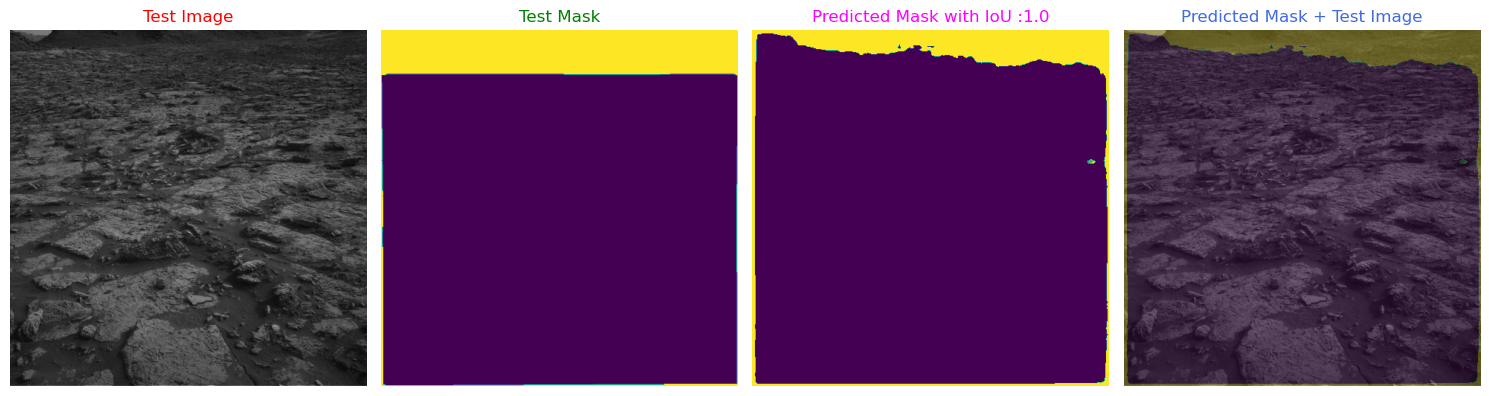

In [41]:
'''CHAINING ALL FUNCTIONS TOGETHER'''
test_img = preprocess_input(input_img)
test_mask,predicted_mask=model_prediction(test_img,test_mask_path)
IoU=iou_score(test_mask,predicted_mask)
plot(test_img,test_mask,predicted_mask,IoU)

## Random 5 Images Prediction

Enter 5 numbers below 6065 with spaces: 44 1259 85 235 6064



1/1 [==============================] - 2s 2s/step
44th Image :-


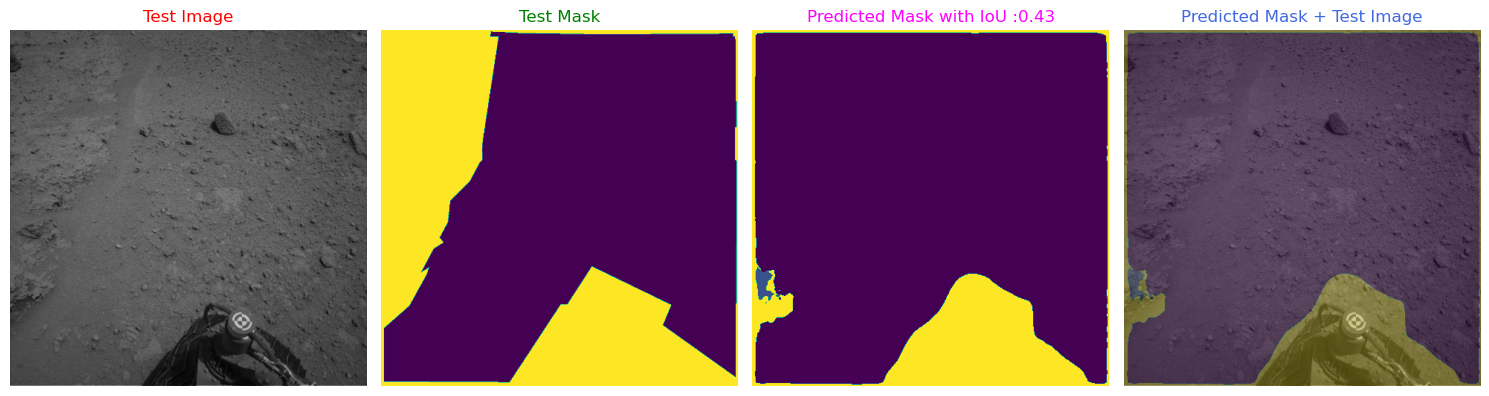


1/1 [==============================] - 2s 2s/step
1259th Image :-


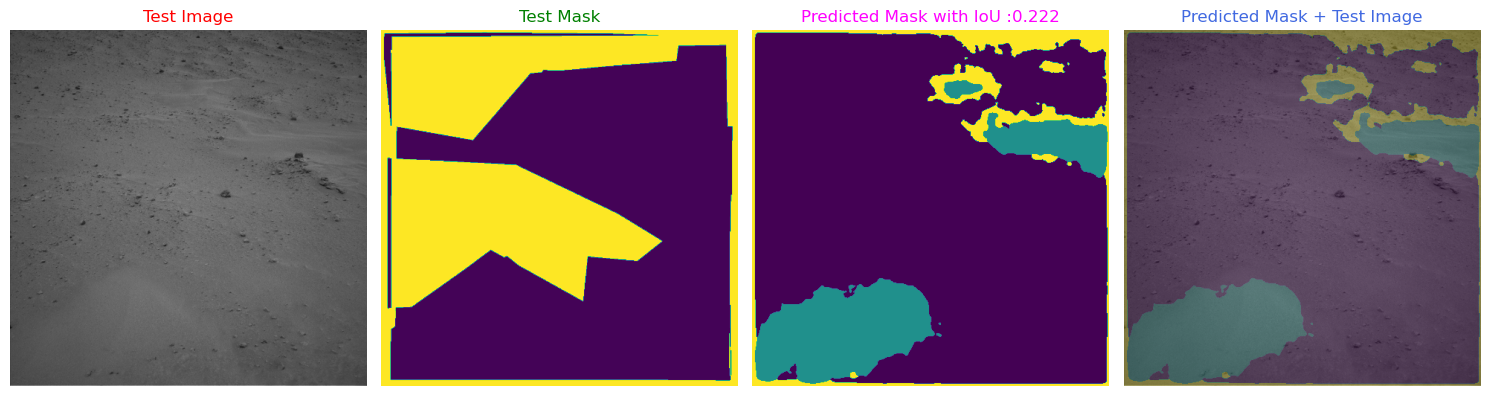


1/1 [==============================] - 2s 2s/step
85th Image :-


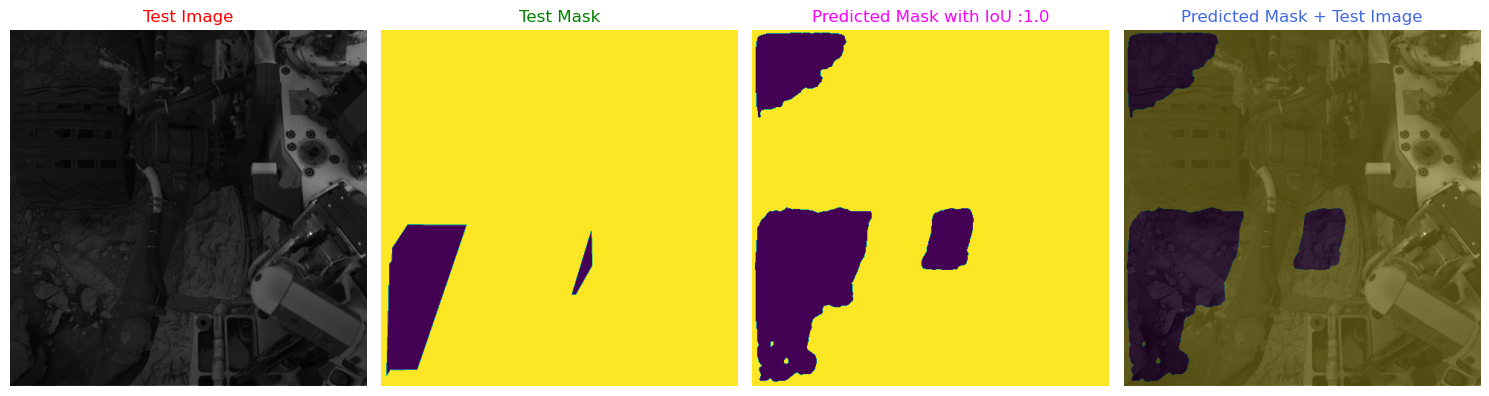


1/1 [==============================] - 2s 2s/step
235th Image :-


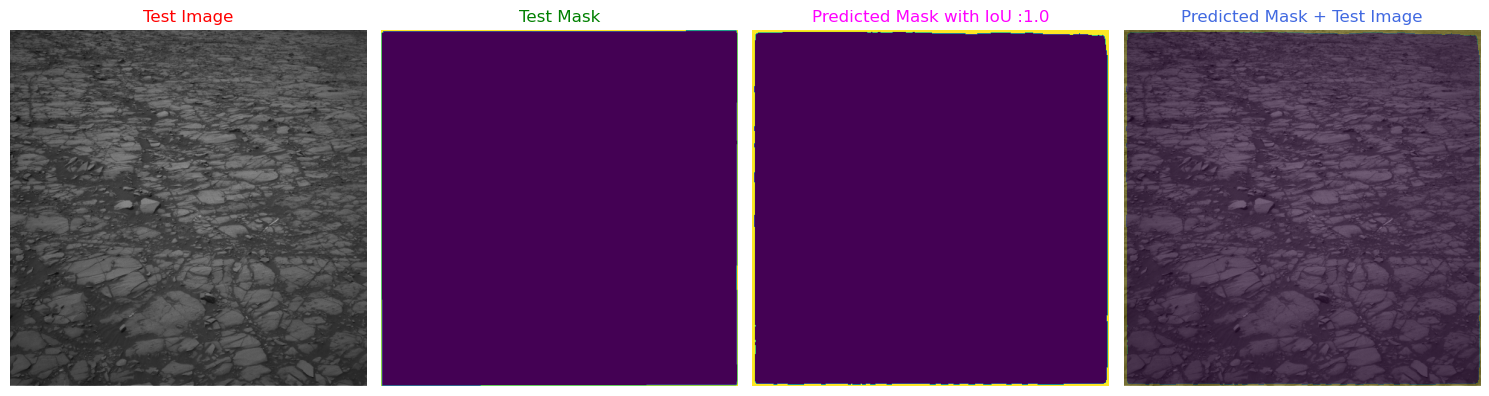


1/1 [==============================] - 2s 2s/step
6064th Image :-


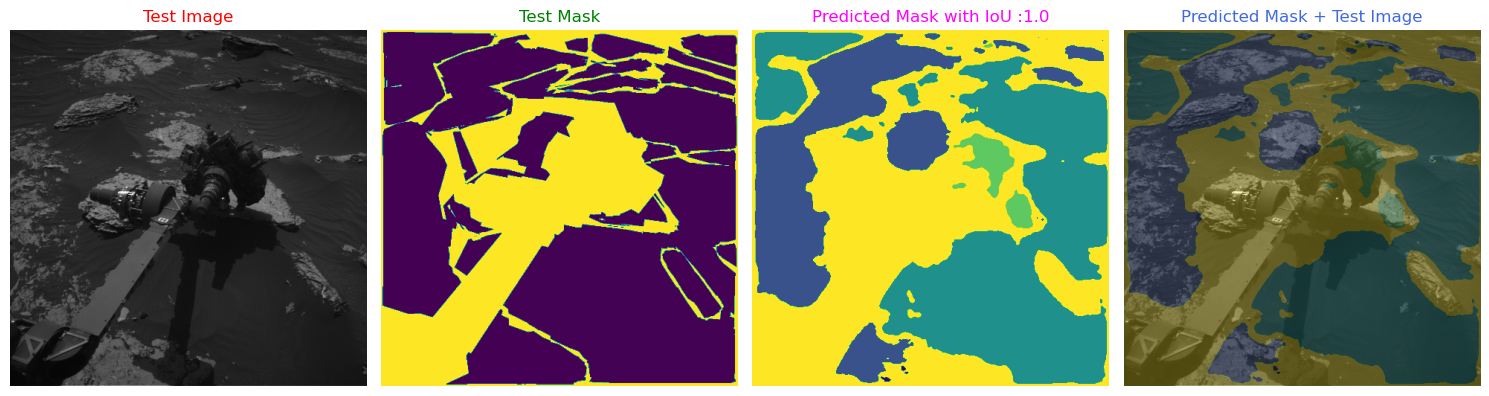

In [48]:

input_five_num = input("Enter 5 numbers below 6065 with spaces:")
user_inputs = list(map(int,input_five_num.strip().split()))
print()
for num in user_inputs:
    for index,image in enumerate(test_img_dir):
        if num-1 == index:
            input_img = image
            test_mask_path = test_mask_dir[index]
            test_img = preprocess_input(input_img)
            test_mask,predicted_mask=model_prediction(test_img,test_mask_path)
            IoU=iou_score(test_mask,predicted_mask)
            print(f'{num}th Image :-')
            plot(test_img,test_mask,predicted_mask,IoU)
            IoU=0
            print()
            break


Model experiments file : https://docs.google.com/spreadsheets/d/1kz8lgzZVT_LtWlFPTejNiqFwmiHJ_uw2/edit?usp=sharing&ouid=114818201103426186765&rtpof=true&sd=true

---

# <center> THE END 